In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pandas_datareader import data, wb
import zipline
import pytz
import datetime as dt
from pymc3.distributions.timeseries import GaussianRandomWalk
import scipy.optimize as sco
import scipy.interpolate as itp

In [2]:
%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

Populating the interactive namespace from numpy and matplotlib


In [3]:
x = np.linspace(0, 10, 500)
y = 4 + 2 * x + np.random.standard_normal(len(x)) * 2

In [4]:
reg = np.polyfit(x, y, 1)
print(reg)

[ 2.04733092  3.61579739]


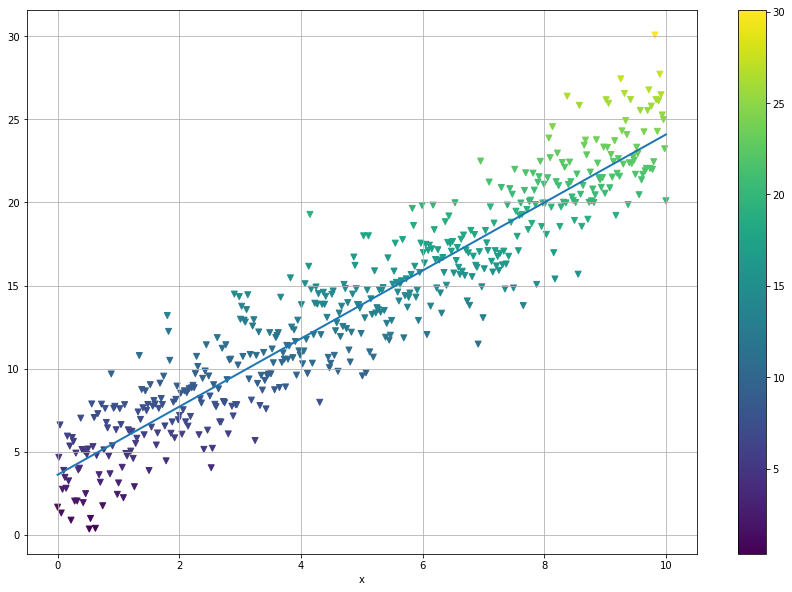

In [5]:
plt.scatter(x, y, c=y, marker='v')
plt.plot(x, reg[1] + reg[0] * x, lw=2.0)
plt.colorbar()
plt.grid(True)
plt.xlabel('x')


In [6]:
%%time
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y_est = alpha + beta * x
    
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start)

Optimization terminated successfully.
         Current function value: 1091.540793
         Iterations: 16
         Function evaluations: 22
         Gradient evaluations: 22


100%|██████████| 100/100 [00:05<00:00, 17.18it/s]

CPU times: user 29.9 s, sys: 3.82 s, total: 33.7 s
Wall time: 4min 8s


In [7]:
trace[0]

{'alpha': 3.685535699262533,
 'beta': 2.0353795269952313,
 'sigma': 2.2000227920294524,
 'sigma_interval_': -1.2656530913122257}

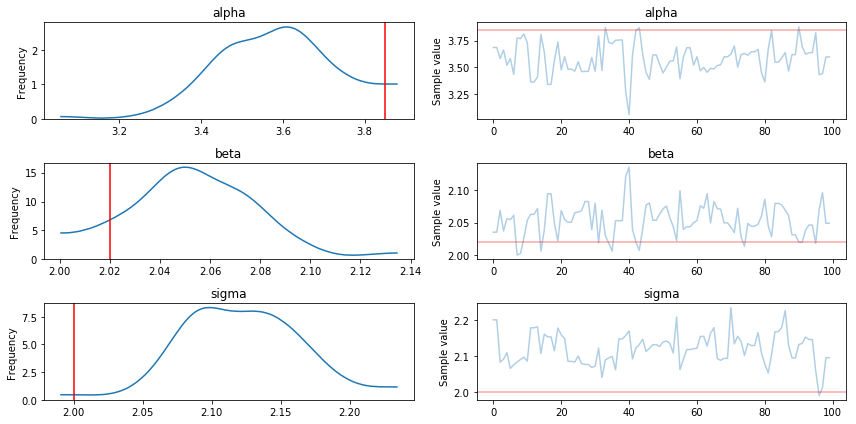

In [8]:
fig = pm.traceplot(trace, lines={'alpha': 3.85, 'beta': 2.02, 'sigma': 2})
plt.figure(figsize=(8,8))

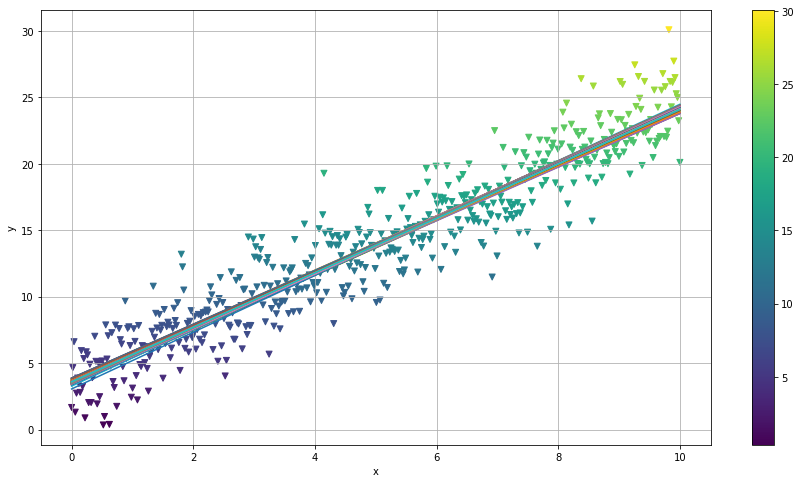

In [9]:
plt.figure(figsize=(15,8))
plt.scatter(x, y, c=y, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('x')
plt.ylabel('y')
for i in range(len(trace)):
    plt.plot(x, trace['alpha'][i] + trace['beta'][i] * x)

In [10]:
dt = zipline.data.load_from_yahoo(stocks=['GLD', 'GDX'],
                                    end=dt.datetime(2014, 3, 15, 0, 0, 0, 0, pytz.utc)).dropna()
dt.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1967 entries, 2006-05-22 to 2014-03-14
Data columns (total 2 columns):
GDX    1967 non-null float64
GLD    1967 non-null float64
dtypes: float64(2)
memory usage: 46.1 KB


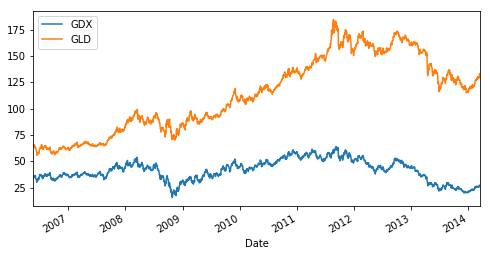

In [11]:
dt.plot(figsize=(8, 4))

In [12]:
dt.ix[-1] / dt.ix[0] - 1

GDX   -0.215999
GLD    1.038285
dtype: float64

In [13]:
dt.corr()

,GDX,GLD
GDX,1.00000,0.46696
GLD,0.46696,1.00000


In [14]:
dt.index

DatetimeIndex(['2006-05-22', '2006-05-23', '2006-05-24', '2006-05-25',
               '2006-05-26', '2006-05-30', '2006-05-31', '2006-06-01',
               '2006-06-02', '2006-06-05',
               ...
               '2014-03-03', '2014-03-04', '2014-03-05', '2014-03-06',
               '2014-03-07', '2014-03-10', '2014-03-11', '2014-03-12',
               '2014-03-13', '2014-03-14'],
              dtype='datetime64[ns, UTC]', name=u'Date', length=1967, freq=None)

In [15]:
mpl_dates = mpl.dates.date2num(dt.index.to_pydatetime())

In [16]:
mpl_dates

array([ 732453.,  732454.,  732455., ...,  735304.,  735305.,  735306.])

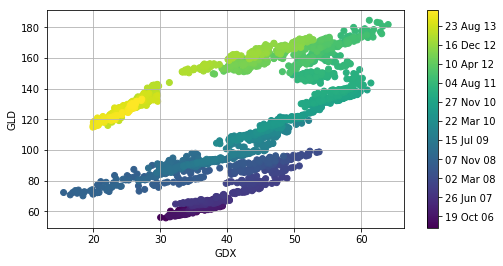

In [17]:
plt.figure(figsize=(8, 4))
plt.scatter(dt['GDX'], dt['GLD'], c=mpl_dates, marker='o')
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))

In [18]:
%%time
with pm.Model() as model:
    alpha = pm.Normal('alpha', mu=0, sd=20)
    beta = pm.Normal('beta', mu=0, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=10)
    
    y_est = alpha + beta * dt['GDX'].values
    
    likelihood = pm.Normal('GLD', mu=y_est, sd=sigma, observed=dt['GLD'].values)
    
    start = pm.find_MAP()
    step = pm.NUTS(state=start)
    trace = pm.sample(100, step, start=start)

         Current function value: 16114.770709
         Iterations: 33
         Function evaluations: 107
         Gradient evaluations: 96


100%|██████████| 100/100 [01:55<00:00,  2.11s/it]

CPU times: user 2min 4s, sys: 2.74 s, total: 2min 7s
Wall time: 2min 17s


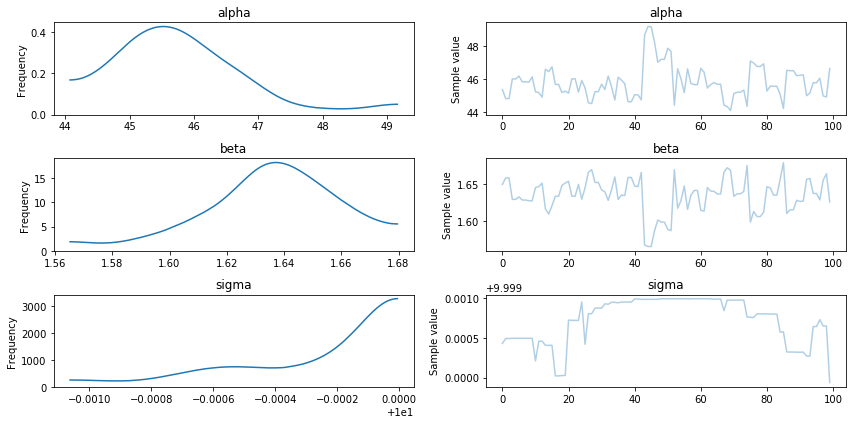

In [19]:
fig = pm.traceplot(trace)
plt.figure(figsize=(8,8))

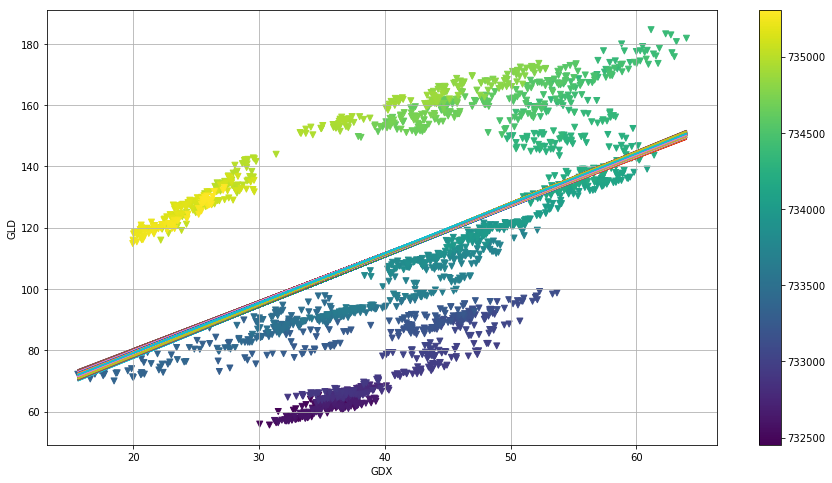

In [20]:
plt.figure(figsize=(15,8))
plt.scatter(dt['GDX'], dt['GLD'], c=mpl_dates, marker='v')
plt.colorbar()
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
for i in range(len(trace)):
    plt.plot(dt['GDX'], trace['alpha'][i] + trace['beta'][i] * dt['GDX'])

In [21]:
model_randomwalk = pm.Model()
with model_randomwalk:
    sigma_alpha = pm.Exponential('sigma_alpha', 1. / .02, testval=.1)
    sigma_beta  = pm.Exponential('sigma_beta' , 1. / .02, testval=.1)

In [22]:
subsample_alpha = 50
subsample_beta = 50

with model_randomwalk:
    alpha = GaussianRandomWalk('alpha', sigma_alpha**-2, shape=len(dt) / subsample_alpha)
    beta  = GaussianRandomWalk('beta' , sigma_beta**-2 , shape=len(dt) / subsample_beta)
    
    alpha_r = np.repeat(alpha, subsample_alpha)
    beta_r = np.repeat(beta, subsample_beta)

In [23]:
len(dt.dropna().GDX.values)

1967

In [24]:
with model_randomwalk:
    regression = alpha_r + beta_r * dt.GDX.values[:1950]
    
    sd = pm.Uniform('sd', 0, 20)
    likelihood = pm.Normal('GLD', mu=regression, sd=sd, observed=dt.GLD.values[:1950])

In [25]:
with model_randomwalk:
    start = pm.find_MAP(vars=[alpha, beta], fmin=sco.fmin_l_bfgs_b)
    
    step = pm.NUTS(scaling=start)
    trac_rw = pm.sample(100, step, start=start)

100%|██████████| 100/100 [00:10<00:00,  9.49it/s]


In [26]:
np.shape(trac_rw['alpha'])

(100, 39)

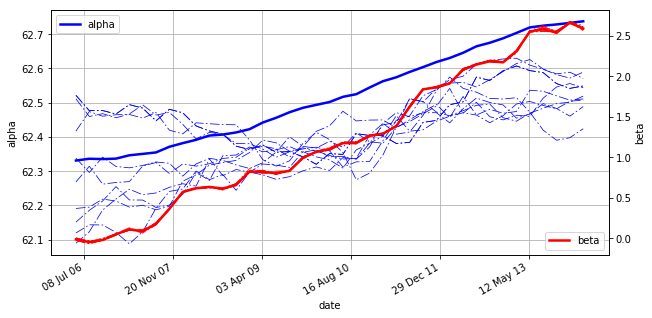

In [27]:
part_dates = np.linspace(min(mpl_dates), max(mpl_dates), 39)
fig, ax1 = plt.subplots(figsize=(10, 5))
plt.plot(part_dates, np.mean(trac_rw['alpha'], axis=0), 'b', lw=2.5, label='alpha')
for i in range(45, 55):
    plt.plot(part_dates, trac_rw['alpha'][i], 'b-.', lw=.75)
plt.xlabel('date')
plt.ylabel('alpha')
plt.axis('tight')
plt.grid(True)
plt.legend(loc=2)
ax1.xaxis.set_major_formatter(mpl.dates.DateFormatter('%d %b %y'))
ax2 = ax1.twinx()
plt.plot(part_dates, np.mean(trac_rw['beta'], axis=0), 'r', lw=2.5, label='beta')
for i in range(45, 55):
    plt.plot(part_dates, trac_rw['beta'][i], 'r-.', lw=.75)
plt.ylabel('beta')
plt.legend(loc=4)
fig.autofmt_xdate()

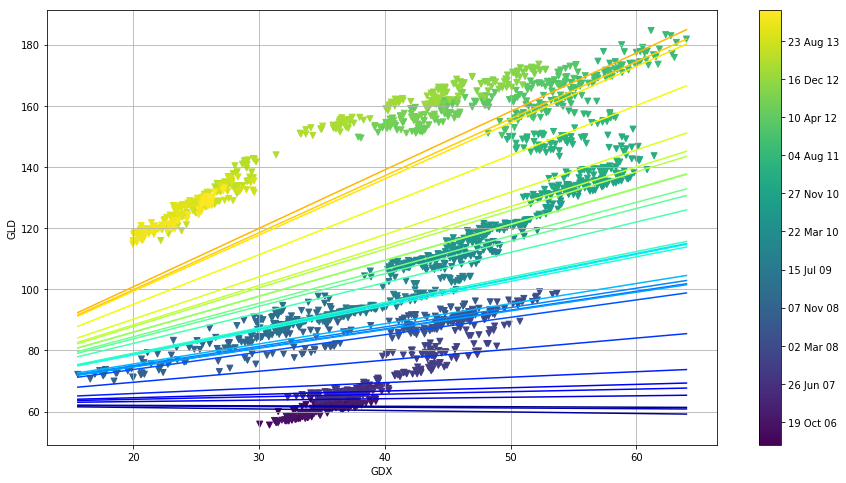

In [28]:
plt.figure(figsize=(15, 8))
plt.scatter(dt['GDX'], dt['GLD'], c=mpl_dates, marker='v')
plt.colorbar(ticks=mpl.dates.DayLocator(interval=250), format=mpl.dates.DateFormatter('%d %b %y'))
plt.grid(True)
plt.xlabel('GDX')
plt.ylabel('GLD')
x = np.linspace(min(dt['GDX']), max(dt['GDX']))
for i in range(29):
    alpha_rw = np.mean(trac_rw['alpha'].T[i])
    beta_rw = np.mean(trac_rw['beta'].T[i])
    plt.plot(x, alpha_rw + beta_rw * x, color=plt.cm.jet(256 * i / 39))

In [29]:
symbols = ['NOW', 'CRM', 'MSFT', 'GLD', 'DB']
noa = len(symbols)

In [33]:
%%time
df = pd.DataFrame()
start = '2014-09-22'
for symbol in symbols:
    print(symbol)
    df[symbol] = data.DataReader(symbol, 'google', start)['Close']


NOW
CRM
MSFT
GLD
DB
CPU times: user 828 ms, sys: 49.8 ms, total: 877 ms
Wall time: 4.29 s


In [35]:
df.head()

,NOW,CRM,MSFT,GLD,DB
Date,,,,,
2014-09-22,60.60,57.32,47.06,116.85,35.89
2014-09-23,59.17,56.81,46.56,117.60,35.28
2014-09-24,60.07,57.66,47.08,117.05,35.76
2014-09-25,58.40,55.92,46.04,117.39,35.04
2014-09-26,59.56,56.56,46.41,117.06,35.37


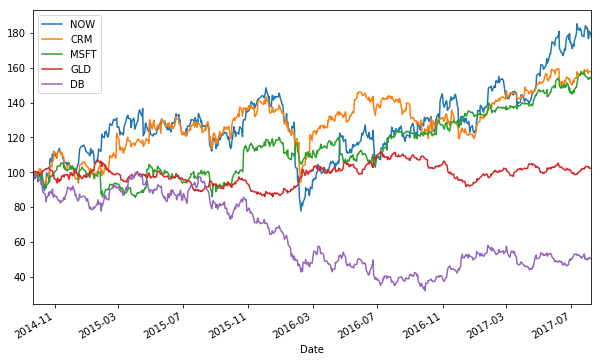

In [36]:
(df / df.ix[0] * 100).plot(figsize=(10,6))

In [37]:
rets = np.log(df / df.shift(1))

In [38]:
rets.mean() * 252

NOW     0.199817
CRM     0.157820
MSFT    0.151602
GLD     0.008840
DB     -0.240058
dtype: float64

In [39]:
rets.cov() * 252

,NOW,CRM,MSFT,GLD,DB
NOW,0.130350,0.064610,0.033627,-0.008142,0.053238
CRM,0.064610,0.088115,0.032286,-0.005886,0.041218
MSFT,0.033627,0.032286,0.053145,-0.004531,0.030429
GLD,-0.008142,-0.005886,-0.004531,0.021482,-0.013634
DB,0.053238,0.041218,0.030429,-0.013634,0.162850


In [40]:
weights = np.random.random(noa)
weights /= np.sum(weights)
weights

array([ 0.11528238,  0.2754819 ,  0.19359964,  0.18415994,  0.23147614])

In [41]:
np.dot(weights.T, rets.mean()) * 252

0.041922157559799965

In [42]:
np.dot(weights.T, np.dot(rets.cov() * 252, weights))

0.037311262704561844

In [43]:
np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))

0.19316123499440008

In [44]:
prets = []
pvols = []
for p in range(2500):
    weights = np.random.random(noa)
    weights = weights / np.sum(weights)
    prets.append(np.dot(weights.T, rets.mean() * 252))
    pvols.append(np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights))))
    
prets = np.array(prets)
pvols = np.array(pvols)

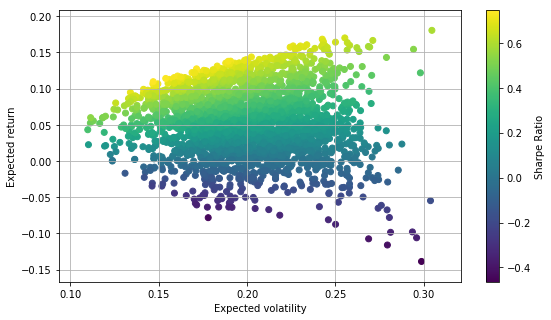

In [45]:
plt.figure(figsize=(9, 5))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.grid(True)
plt.xlabel('Expected volatility')
plt.ylabel('Expected return')
plt.colorbar(label='Sharpe Ratio')

In [46]:
def statistics(weights):
    weights = np.array(weights)
    pret = np.dot(weights.T, rets.mean() * 252)
    pvol = np.sqrt(np.dot(weights.T, np.dot(rets.cov() * 252, weights)))
    return np.array([pret, pvol, pret / pvol])

In [47]:
def min_func_sharpe(weights):
    return -statistics(weights)[2]

In [ ]:
cons = ({'type':'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(noa))

In [ ]:
%%time
opts = sco.minimize(min_func_sharpe, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
opts

In [ ]:
opts['x'].round(3)

In [ ]:
symbols

In [ ]:
statistics(opts['x'].round(3))

In [ ]:
def min_func_variance(weights):
    return statistics(weights)[1] ** 2

In [ ]:
%%time
optv = sco.minimize(min_func_variance, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
optv['x'].round(3)

In [ ]:
statistics(optv['x'].round(3))

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})

In [ ]:
def min_func_port(weights):
    return statistics(weights)[1]

In [ ]:
%%time
trets = np.linspace(0.0, 0.25, 50)
tvols = []
for tret in trets:
    cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - tret},
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

In [ ]:
plt.figure(figsize=(10,6))
plt.scatter(pvols, prets, c=prets/pvols, marker='o')
plt.scatter(tvols, trets, c=trets/tvols, marker='x')
plt.plot(statistics(opts['x'])[1], statistics(opts['x'])[0], 'r*', markersize=15.0)
plt.plot(statistics(optv['x'])[1], statistics(optv['x'])[0], 'y*', markersize=15.0)
plt.grid(True)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe Ratio')

In [ ]:
ind = np.argmin(tvols)
evols = tvols[ind:][:30]
erets = trets[ind:][:30]

In [ ]:
evols

In [ ]:
erets

In [ ]:
plt.scatter(evols, erets)

In [ ]:
tck = itp.splrep(evols, erets)

In [ ]:
def f(x):
    return itp.splev(x, tck, der=0)

def df(x):
    return itp.splev(x, tck, der=1)

In [ ]:
def equations(p, rf=0.01):
    eq1 = rf - p[0]
    eq2 = rf + p[1] * p[2] - f(p[2])
    eq3 = p[1] - df(p[2])
    return eq1, eq2, eq3
    
opt = sco.fsolve(equations, [0.01, 0.5, 0.15])

In [ ]:
opt

In [ ]:
np.round(equations(opt), 6)

In [ ]:
plt.figure(figsize=(8, 4))
plt.scatter(pvols, prets, c=(prets - 0.01) / pvols, marker='o')
plt.plot(evols, erets, 'g', lw=4.0)
cx = np.linspace(.0, .3)
plt.plot(cx, opt[0] + opt[1] * cx, lw=1.5)
plt.plot(opt[2], f(opt[2]), 'r*', markersize=15.0)
plt.grid(True)
plt.title('Capital Market Line')
plt.axhline(0, color='k', ls='-', lw=2.0)
plt.axhline(0, color='k', ls='-', lw=2.0)
plt.xlabel('expected volatility')
plt.ylabel('expected return')
plt.colorbar(label='Sharpe Ratio')

In [ ]:
cons = ({'type': 'eq', 'fun': lambda x: statistics(x)[0] - f(opt[2])},
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP', bounds=bnds, constraints=cons)

In [ ]:
res['x'].round(3)